In [1]:
# THIS VERSION IS FOR PYTHON 2 #
import urllib2
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.finance import candlestick_ochl
import matplotlib
import pylab
from pandas import Series

params = {'axes.labelsize': 18,'axes.titlesize':20, 'font.size': 20, 'legend.fontsize': 20, 'xtick.labelsize': 18, 'ytick.labelsize': 18}
matplotlib.rcParams.update(params)
%matplotlib inline

def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

def movingaverage(values,window):
    weigths = np.repeat(1.0, window)/window
    smas = np.convolve(values, weigths, 'valid')
    return smas # as a numpy array

def ExpMovingAverage(seriesp, window):
    ema=seriesp.ewm(span=window).mean().values
    ema[:window] = ema[window]
    return ema

def computeMACD(seriesp, slow=26, fast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = ExpMovingAverage(seriesp, slow)
    emafast = ExpMovingAverage(seriesp, fast)
    return emaslow, emafast, emafast - emaslow

def graphData(stock,MA1,MA2):
    '''
        Use this to dynamically pull a stock:
    '''
    try:
        print 'Currently Pulling',stock
        print str(datetime.datetime.fromtimestamp(int(time.time())).strftime('%Y-%m-%d %H:%M:%S'))
        urlToVisit = 'http://chartapi.finance.yahoo.com/instrument/1.0/'+stock+'/chartdata;type=quote;range=1y/csv'
        stockFile =[]
        try:
            sourceCode = urllib2.urlopen(urlToVisit).read()
            splitSource = sourceCode.split('\n')
            for eachLine in splitSource:
                splitLine = eachLine.split(',')
                if len(splitLine)==6:
                    if 'values' not in eachLine:
                        stockFile.append(eachLine)
        except Exception, e:
            print str(e), 'failed to organize pulled data.'
    except Exception,e:
        print str(e), 'failed to pull pricing data'
    try:   
        date, closep, highp, lowp, openp, volume = np.loadtxt(stockFile,delimiter=',', unpack=True,
                                                              converters={ 0: mdates.strpdate2num('%Y%m%d')})
        x = 0
        y = len(date)
        newAr = []
        while x < y:
            appendLine = date[x],openp[x],closep[x],highp[x],lowp[x],volume[x]
            newAr.append(appendLine)
            x+=1
            
        Av1 = movingaverage(closep, MA1)
        Av2 = movingaverage(closep, MA2)

        SP = len(date[MA2-1:])
            
        fig = plt.figure(facecolor='#07000d', figsize=(16,12))

        ax1 = plt.subplot2grid((8,6), (2,0), rowspan=4, colspan=4, axisbg='#07000d')
        candlestick_ochl(ax1, newAr[-SP:], width=.6, colorup='#53c156', colordown='#ff1717')

        Label1 = str(MA1)+' SMA'
        Label2 = str(MA2)+' SMA'

        ax1.plot(date[-SP:],Av1[-SP:],'#e1edf9',label=Label1, linewidth=1.5)
        ax1.plot(date[-SP:],Av2[-SP:],'#4ee6fd',label=Label2, linewidth=1.5)
        
        ax1.grid(True, color='w')
        ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.yaxis.label.set_color("w")
        ax1.spines['bottom'].set_color("#5998ff")
        ax1.spines['top'].set_color("#5998ff")
        ax1.spines['left'].set_color("#5998ff")
        ax1.spines['right'].set_color("#5998ff")
        ax1.tick_params(axis='y', colors='w')
        plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
        ax1.tick_params(axis='x', colors='w')
        plt.ylabel('Stock price')

        maLeg = plt.legend(loc=9, ncol=2, prop={'size':16},
                   fancybox=True, borderaxespad=0.)
        maLeg.get_frame().set_alpha(0.4)
        textEd = pylab.gca().get_legend().get_texts()
        pylab.setp(textEd[0:5], color = 'w')

        volumeMin = 0
        
        ax0 = plt.subplot2grid((8,6), (6,0), sharex=ax1, rowspan=2, colspan=4, axisbg='#07000d')
        rsi = rsiFunc(closep)
        rsiCol = '#c1f9f7'
        posCol = '#386d13'
        negCol = '#8f2020'
        
        ax0.plot(date[-SP:], rsi[-SP:], rsiCol, linewidth=1.5)
        ax0.axhline(70, color=negCol)
        ax0.axhline(30, color=posCol)
        ax0.axhline(50, color=rsiCol)
        ax0.fill_between(date[-SP:], rsi[-SP:], 70, where=(rsi[-SP:]>=70), facecolor=negCol, edgecolor=negCol, alpha=1)
        ax0.fill_between(date[-SP:], rsi[-SP:], 30, where=(rsi[-SP:]<=30), facecolor=posCol, edgecolor=posCol, alpha=1)
        ax0.set_yticks([30,50,70])
        ax0.yaxis.label.set_color("w")
        ax0.spines['bottom'].set_color("#5998ff")
        ax0.spines['top'].set_color("#5998ff")
        ax0.spines['left'].set_color("#5998ff")
        ax0.spines['right'].set_color("#5998ff")
        ax0.tick_params(axis='y', colors='w')
        ax0.tick_params(axis='x', colors='w')
        plt.ylabel('RSI')

        ax1v = ax1.twinx()
        ax1v.fill_between(date[-SP:],volumeMin, volume[-SP:], facecolor='#00ffe8', alpha=.35)
        ax1v.axes.yaxis.set_ticklabels([])
        ax1v.grid(False)
        ###Edit this to 3, so it's a bit larger
        ax1v.set_ylim(0, 3*volume.max())
        ax1v.spines['bottom'].set_color("#5998ff")
        ax1v.spines['top'].set_color("#5998ff")
        ax1v.spines['left'].set_color("#5998ff")
        ax1v.spines['right'].set_color("#5998ff")
        ax1v.tick_params(axis='x', colors='w')
        ax1v.tick_params(axis='y', colors='w')
        ax2 = plt.subplot2grid((8,6), (0,0), sharex=ax1, rowspan=2, colspan=4, axisbg='#07000d')
        fillcolor = '#00ffe8'
        nslow = 26
        nfast = 12
        nema = 9
        
        emaslow, emafast, macd = computeMACD(Series(closep,date))
        ema9 = ExpMovingAverage(Series(macd,date), nema)
        ax2.plot(date[-SP:], macd[-SP:], color='#4ee6fd', lw=2)
        ax2.plot(date[-SP:], ema9[-SP:], color='#e1edf9', lw=1)
        ax2.fill_between(date[-SP:], macd[-SP:]-ema9[-SP:], 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)

        plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
        ax2.spines['bottom'].set_color("#5998ff")
        ax2.spines['top'].set_color("#5998ff")
        ax2.spines['left'].set_color("#5998ff")
        ax2.spines['right'].set_color("#5998ff")
        ax2.tick_params(axis='x', colors='w')
        ax2.tick_params(axis='y', colors='w')
        plt.ylabel('MACD', color='w')
        ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
        for label in ax0.xaxis.get_ticklabels():
            label.set_rotation(45)

        plt.suptitle(stock.upper(), x=0.37, color='w', fontsize=20)

        plt.setp(ax0.get_xticklabels(), visible=True)
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)
        
# text annotation omitted here
#        ax1.annotate('Big news!',(date[510],Av1[510]),
#            xytext=(0.8, 0.9), textcoords='axes fraction',
#            arrowprops=dict(facecolor='white', shrink=0.05),
#            fontsize=14, color = 'w',
#            horizontalalignment='right', verticalalignment='bottom')

        plt.subplots_adjust(left=.09, bottom=.14, right=.94, top=.95, wspace=.20, hspace=0)
        plt.show()
        fig.savefig('example.png',facecolor=fig.get_facecolor())
           
    except Exception,e:
        print 'main loop',str(e)


In [ ]:
# Plots to draw: sector rotation, pay attention to agriculture (trend in the coming years?), emerging market, oil/gold, etc.

Currently Pulling ^VIX
2016-07-01 21:43:45


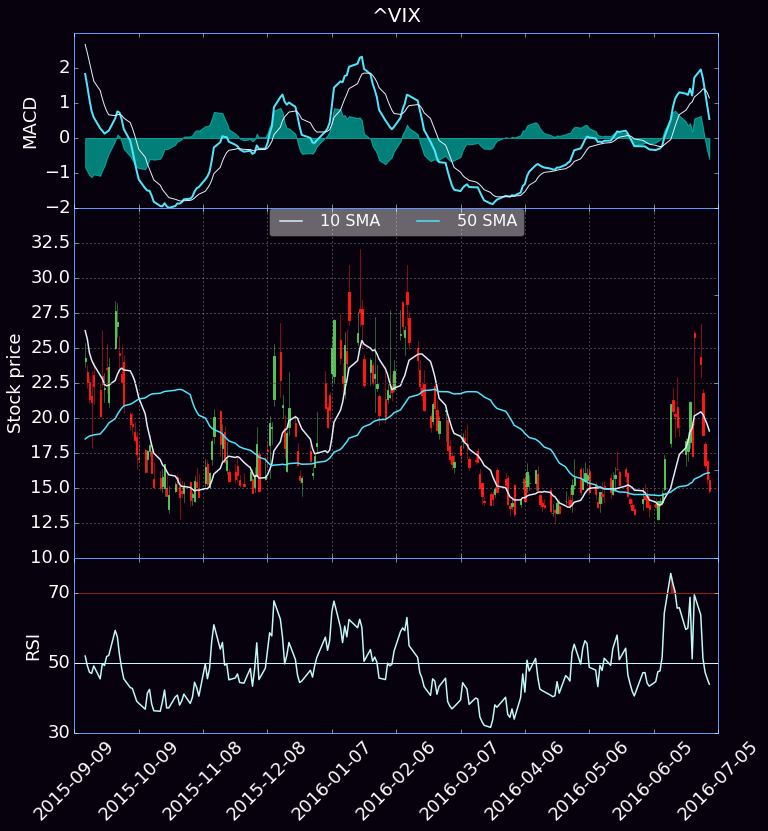

In [13]:
graphData('^VIX',10,50)

Currently Pulling SPY
2016-07-01 21:44:08


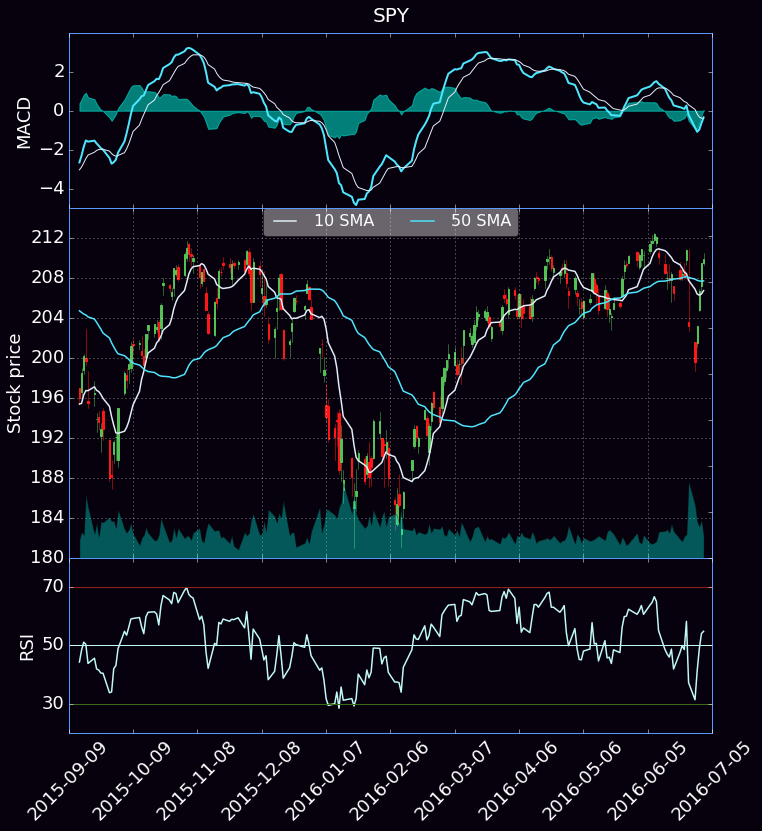

In [14]:
graphData('SPY',10,50)

Currently Pulling QQQ
2016-07-01 21:44:11


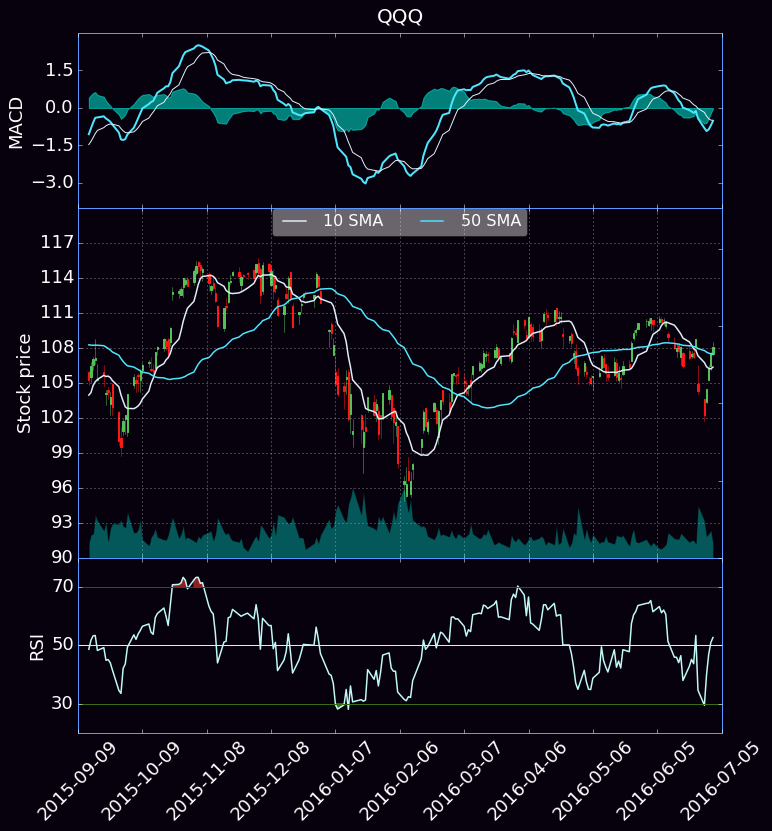

In [15]:
graphData('QQQ',10,50)

Currently Pulling IWM
2016-07-01 21:44:14


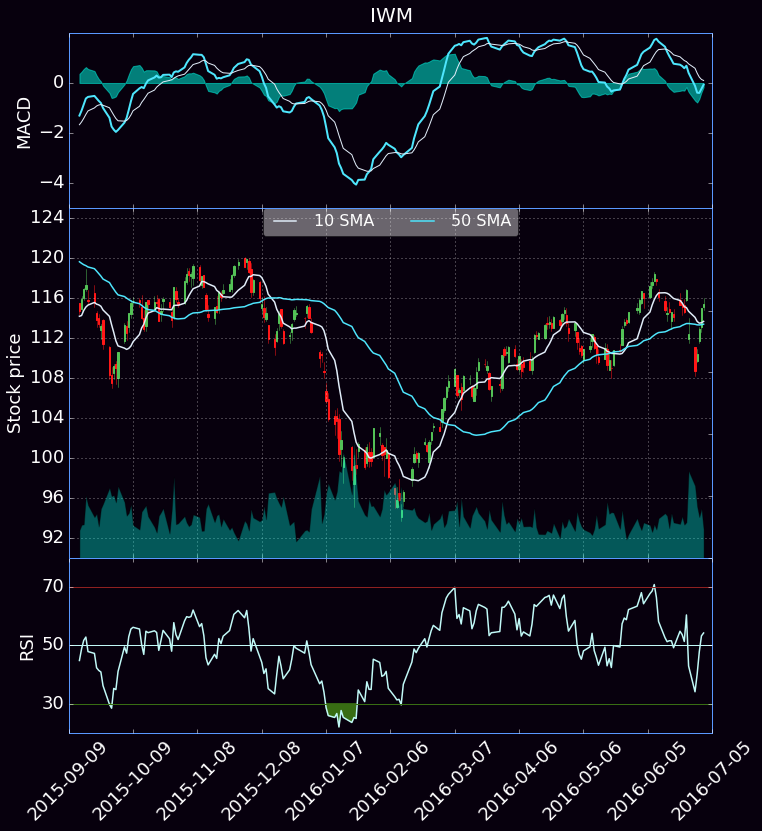

In [16]:
graphData('IWM',10,50)

Currently Pulling DIA
2016-07-01 21:44:17


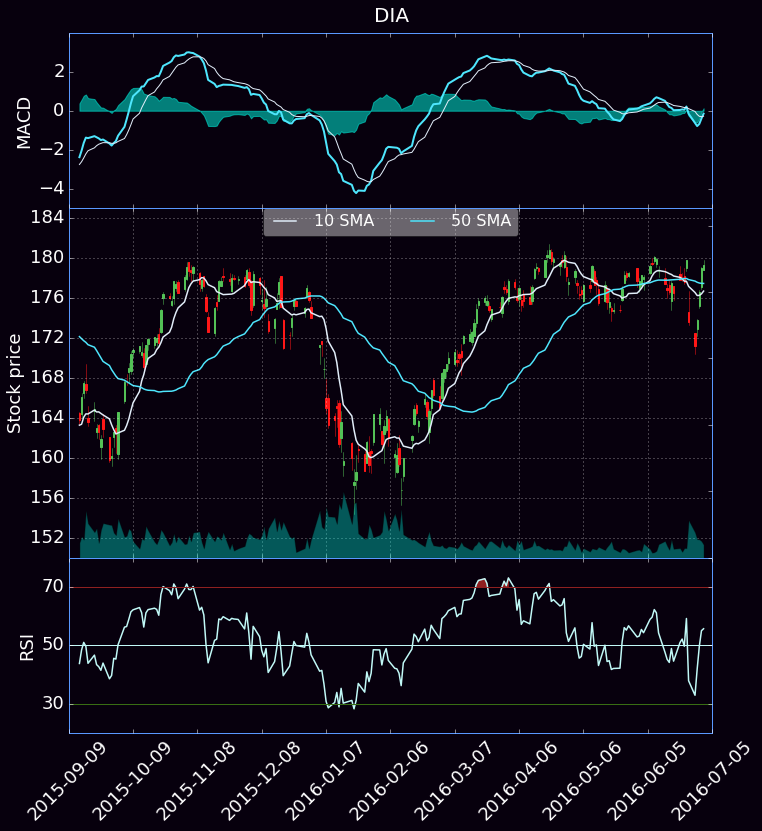

In [17]:
graphData('DIA',10,50)

Currently Pulling USO
2016-07-01 21:44:19


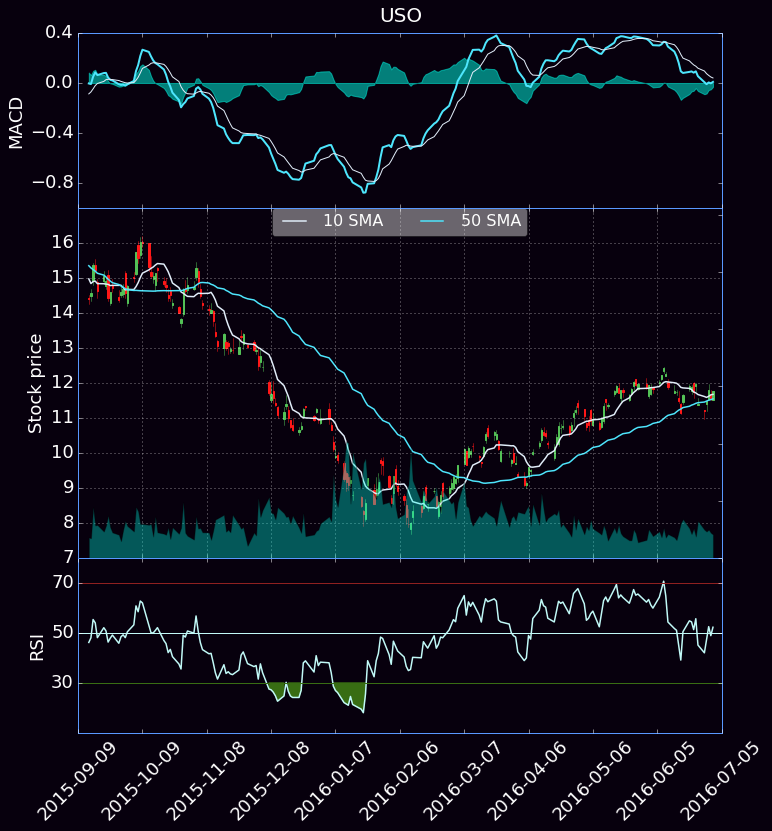

In [18]:
graphData('USO',10,50)

Currently Pulling GLD
2016-07-01 21:44:22


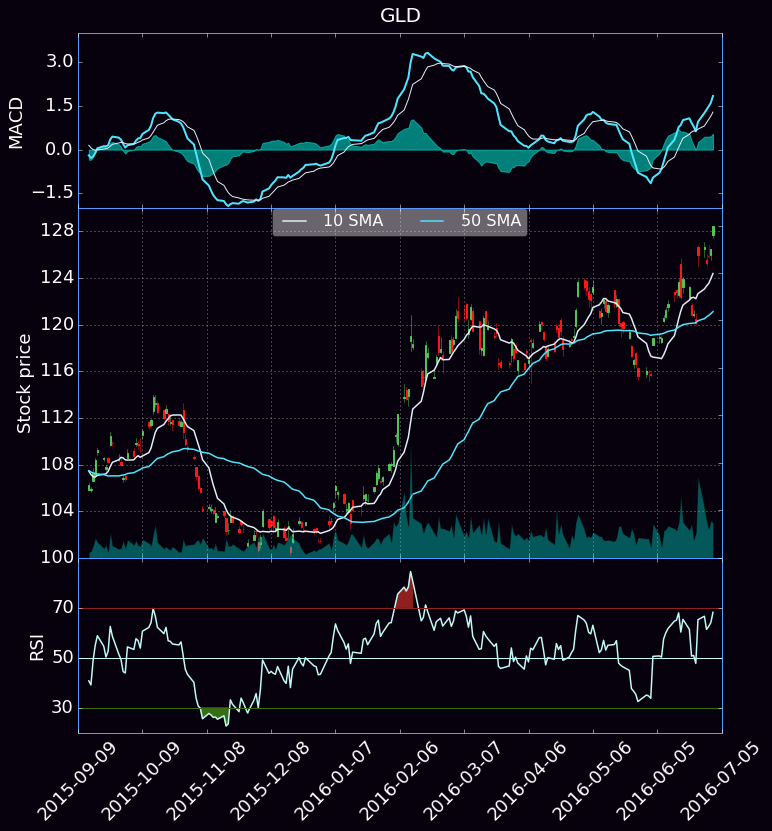

In [19]:
graphData('GLD',10,50)

Currently Pulling GDX
2016-07-01 21:44:25


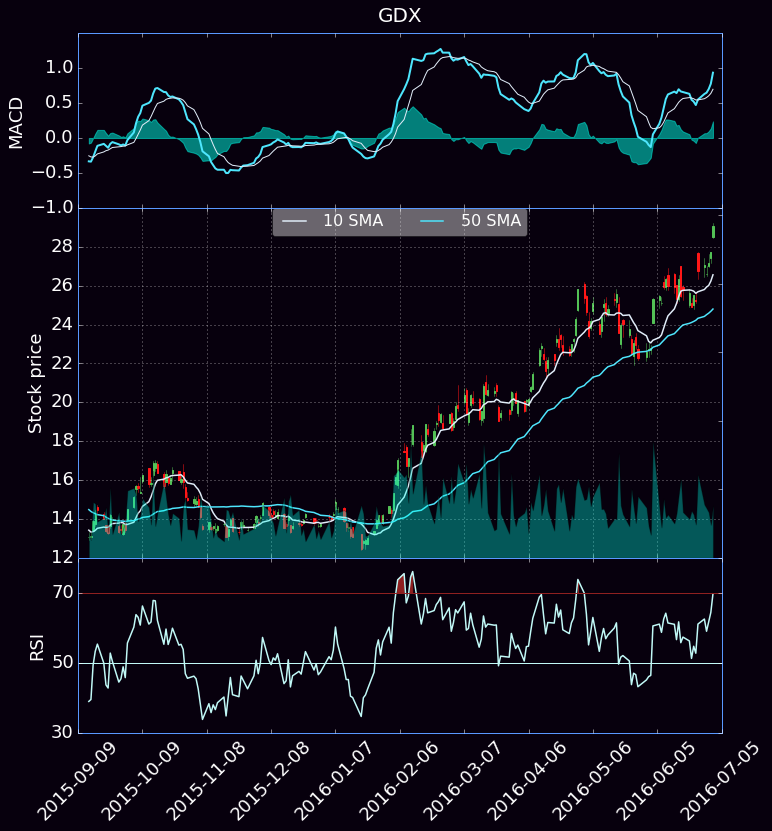

In [20]:
graphData('GDX',10,50)

Currently Pulling XLF
2016-07-01 21:44:27


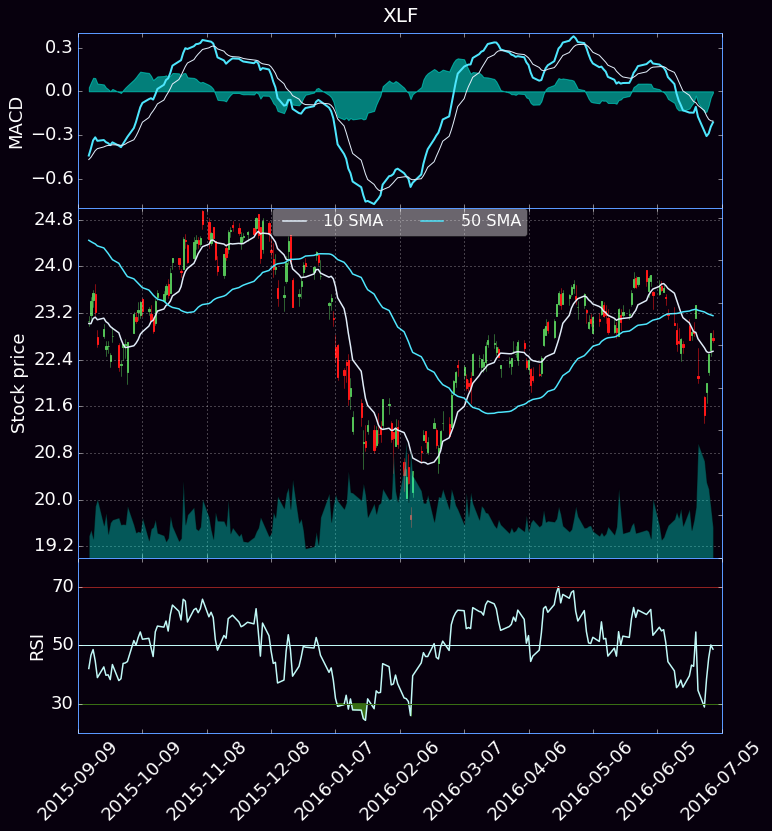

In [21]:
graphData('XLF',10,50)

Currently Pulling XLE
2016-07-01 21:44:38


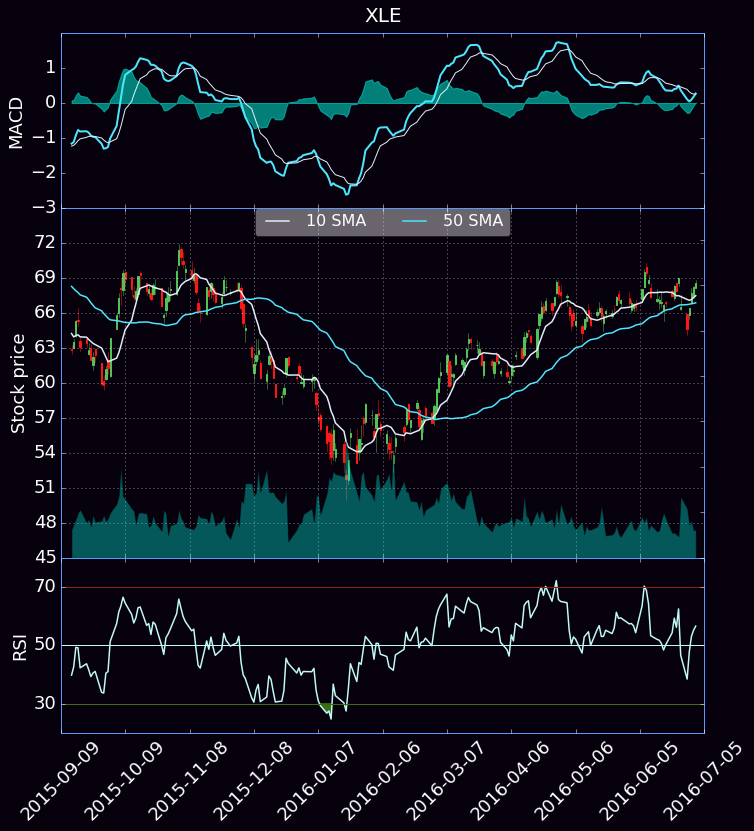

In [22]:
graphData('XLE',10,50)